# Download, interpolate and dump of GPS data

e.g. will build a file  `velocity_cat=custom_ASlag=45_MS=5.5.npy`

## Basic Utils (MANDATORY)

In [2]:
import seismicutils
from seismicutils import SeismicUtils
import numpy as np
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
if(True):
    reload(seismicutils)
from sklearn.metrics.pairwise import haversine_distances
import os
import networkx as nx
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import warnings

from numba import njit

In [4]:
#pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Specify the folder where to put csv files of GPS data

In [5]:
#rootpath="/home/flandes/csv/"
rootpath="/Users/gloirelinvani/gps_csv/"
#rootpath="D:/gps/"
if(not os.path.exists(rootpath)):
    os.mkdir(rootpath)

## Main body

### Catalog loading

In [6]:
R0 = 6371  ## Earth's Radius
R_search = 300   ## Radius (in km) for which we look for GPS stations
## we predict aftershocks up to 45 days after the MS:
aftershocks_time_window = np.timedelta64(45,'D') 
min_mainshock_mag = 6 # this is telling us the minimal mainshock magnitude

In [7]:
catalog_type = 'custom' # just a flag for the output file
catalog_filename = "/New_code/custom_catalog.csv"  # valid values: 'custom' or 'giuseppe'

In [8]:
n_days_forward  = np.timedelta64(1,'D')  ## how many days of GPS data to use after the MS 
n_days_backward = np.timedelta64(8, 'D') ## how many days of GPS data to use before the MS
n_total_days = 1 +  n_days_forward.astype('int')+  n_days_backward.astype('int')
## total will be 4+1(MS day)+1
n_total_days

10

In [9]:
regions = seismicutils.return_regions() 

In [10]:
fit_catalog = pd.read_csv(catalog_filename, sep=" ", parse_dates=['datetime'])
fit_catalog['day'] = fit_catalog.datetime.values.astype('datetime64[D]')
fit_catalog.sort_values(by='day', inplace=True)
fit_catalog.reset_index(drop=True, inplace=True)

In [11]:
#mainshocks = fit_catalog[fit_catalog.type==1]
#mainshocks.reset_index(inplace=True, drop=True)
#drop_ids = set()
#for i in range(0, len(mainshocks)):
#    if(mainshocks.iloc[i].seq_id in drop_ids):
#        continue
#    for j in range(i+1, len(mainshocks)):
#        delta_days = (mainshocks.iloc[j].day.to_numpy() - mainshocks.iloc[i].day.to_numpy()).astype('timedelta64[D]')
#        if(delta_days > aftershocks_time_window):
#            break
#        arg1 = np.radians(np.array([mainshocks.iloc[i].lat, mainshocks.iloc[i].lon]))[None,:]
#        arg2 = np.radians(np.array([mainshocks.iloc[j].lat, mainshocks.iloc[j].lon]))[None,:]
#        d_ij = R0*haversine_distances(arg1, arg2)[0,0]
#        if(d_ij < R_search):
#            print(mainshocks.iloc[j].seq_id,delta_days, d_ij, mainshocks.iloc[j].day.to_numpy())
#            drop_ids.add(mainshocks.iloc[j].seq_id)
#print('TO DROP SZ:', len(drop_ids))

### GPS stations and Mainshocks (TO BE RUN ONLY THE FIRST TIME, OR IF SOMETHING CHANGED)

#### Load the correct catalog (if the previous cell has run, it is already saved locally)

This is useful if we previously run and saved the catalog part of the notebook

#### Download and plot stations (spatial distribution)
We first download the list of all stations, then plot the distribution of the minimal station-to-station distance 

In [12]:
stations = SeismicUtils.get_ngl_stations()
stations.shape

(21941, 8)

In [13]:
len(stations.name.unique())

21941

In [4]:
t = np.array([1,2,3])
3 - t

array([2, 1, 0])

In [14]:
jlist_distances = haversine_distances(np.radians(stations[['lat','lon']].values))

In [17]:
t = R0*np.sort(jlist_distances, axis=0)

In [22]:
jlist_distances[0:3,:10]

array([[0.        , 0.00236041, 0.00203614, 1.91317678, 1.91064757,
        1.97828688, 1.95632819, 1.96006675, 1.96673854, 2.01400969],
       [0.00236041, 0.        , 0.00273478, 1.91421887, 1.9118233 ,
        1.9796709 , 1.95769292, 1.96130255, 1.96802651, 2.0153994 ],
       [0.00203614, 0.00273478, 0.        , 1.91160956, 1.90916687,
        1.97696096, 1.95498681, 1.95862807, 1.96533801, 2.0126884 ]])

In [18]:
t.shape

(21941, 21941)

In [27]:
t[1:2,:10]

array([[ 2.43198621,  4.80524841,  0.        , 45.90452229, 10.69168265,
         8.56220293, 16.23603482, 33.64187462, 29.53218415, 10.66054949]])

In [28]:
t[1:2,:10].mean(axis=0)

array([ 2.43198621,  4.80524841,  0.        , 45.90452229, 10.69168265,
        8.56220293, 16.23603482, 33.64187462, 29.53218415, 10.66054949])

(array([1., 1., 1., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([  0.        ,   2.04081633,   4.08163265,   6.12244898,
          8.16326531,  10.20408163,  12.24489796,  14.28571429,
         16.32653061,  18.36734694,  20.40816327,  22.44897959,
         24.48979592,  26.53061224,  28.57142857,  30.6122449 ,
         32.65306122,  34.69387755,  36.73469388,  38.7755102 ,
         40.81632653,  42.85714286,  44.89795918,  46.93877551,
         48.97959184,  51.02040816,  53.06122449,  55.10204082,
         57.14285714,  59.18367347,  61.2244898 ,  63.26530612,
         65.30612245,  67.34693878,  69.3877551 ,  71.42857143,
         73.46938776,  75.51020408,  77.55102041,  79.59183673,
         81.63265306,  83.67346939,  85.71428571,  87.75510204,
         89.79591837,  91.83673469,  93.87755102,  95.91836735,
         9

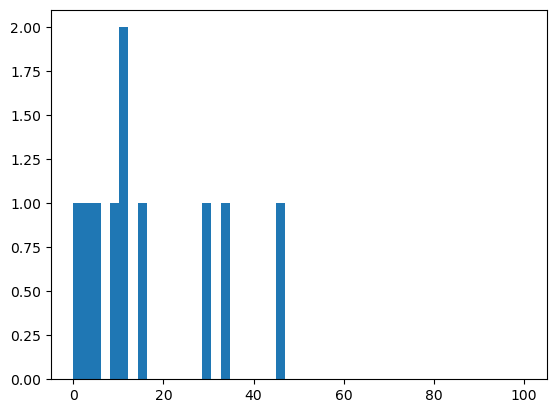

In [30]:
plt.hist(t[1:2,:10].mean(axis=0), bins=np.linspace(0, 1e2))

In [20]:
t2 = np.array([[10,3,2],[4,2,5]])
t2.sort(axis=0)

array([[ 4,  2,  2],
       [10,  3,  5]])

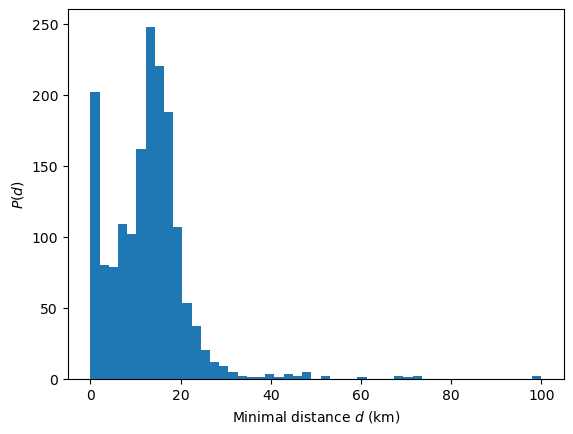

In [36]:
ngl_list = SeismicUtils.get_ngl_stations(post_process=True)
plot_station_distribution = True
if(plot_station_distribution):
    jlist = ngl_list[(ngl_list.lat>= regions['japan'][0])*(ngl_list.lat<= regions['japan'][1])\
                    *(ngl_list.lon >= regions['japan'][2])*(ngl_list.lon<= regions['japan'][3])]
    jlist_distances = haversine_distances(np.radians(jlist[['lat','lon']].values))
    plt.hist(R0*np.sort(jlist_distances, axis=0)[1:2,:].mean(axis=0), bins=np.linspace(0, 1e2))
    plt.xlabel('Minimal distance $d$ (km)')
    plt.ylabel('$P(d)$')
    plt.show()

### Conclusion:

most stations have a neighboring one in a distance < 20km. 

So, $\sigma_{interpolation}$ can be of the order of 20 km. 

For extrapolation (i.e. the choice of `alpha_max_dist`), one should take sthg of the order of 20km or a bit more (a bit more than  $\sigma_{interpolation}$ for sure), but not much more than 20km.

#### For each Mainshock, we find all stations around in a large radius (much larger than our future box). 

We discard MS that have too few stations (but not in a very restrictive way, for now)

"*Actual selection of mainshocks vs stations collection*"

In [3]:
data = SeismicUtils.get_ngl_gps_data("1LSU","IGS14", "tenv3")

In [5]:
data.head(10)

,site,YYMMMDD,yyyy.yyyy,__MJD,week,d,reflon,_e0(m),__east(m),____n0(m),...,_ant(m),sig_e(m),sig_n(m),sig_u(m),__corr_en,__corr_eu,__corr_nu,_latitude(deg),_longitude(deg),__height(m)
0,1LSU,03APR23,2003.3073,52752,1215,3,-91.2,1896,0.711049,3365278,...,0.0,0.000744,0.000770,0.002916,0.004143,-0.052295,-0.108750,30.407425,-91.180261,-6.51332
1,1LSU,03APR24,2003.3101,52753,1215,4,-91.2,1896,0.709828,3365278,...,0.0,0.000751,0.000794,0.003006,-0.004771,-0.073633,-0.084747,30.407425,-91.180261,-6.50968
2,1LSU,03APR25,2003.3128,52754,1215,5,-91.2,1896,0.709516,3365278,...,0.0,0.000764,0.000805,0.003065,-0.033009,-0.032816,-0.099395,30.407425,-91.180261,-6.50972
3,1LSU,03APR26,2003.3155,52755,1215,6,-91.2,1896,0.709294,3365278,...,0.0,0.000746,0.000795,0.002970,-0.031578,-0.034920,-0.066100,30.407425,-91.180261,-6.51368
4,1LSU,03APR27,2003.3183,52756,1216,0,-91.2,1896,0.708491,3365278,...,0.0,0.000730,0.000779,0.002870,0.014876,-0.046110,-0.072286,30.407425,-91.180261,-6.51495
5,1LSU,03APR28,2003.3210,52757,1216,1,-91.2,1896,0.709078,3365278,...,0.0,0.000742,0.000804,0.002976,-0.002140,-0.008859,-0.082712,30.407425,-91.180261,-6.51359
6,1LSU,03APR29,2003.3238,52758,1216,2,-91.2,1896,0.710335,3365278,...,0.0,0.000748,0.000800,0.002983,-0.000612,-0.047110,-0.075062,30.407425,-91.180261,-6.51713
7,1LSU,03APR30,2003.3265,52759,1216,3,-91.2,1896,0.708739,3365278,...,0.0,0.000761,0.000807,0.003038,0.002776,-0.044538,-0.078777,30.407425,-91.180261,-6.51464
8,1LSU,03MAY01,2003.3292,52760,1216,4,-91.2,1896,0.708631,3365278,...,0.0,0.000762,0.000803,0.003001,0.000272,-0.043905,-0.084195,30.407425,-91.180261,-6.52050
9,1LSU,03MAY02,2003.3320,52761,1216,5,-91.2,1896,0.710395,3365278,...,0.0,0.000792,0.000815,0.003160,-0.000469,-0.079799,-0.077296,30.407425,-91.180261,-6.51699


In [ ]:
## we ask for min_station_number to be there, but in a very large radius !
## so we may further filter later
min_station_number = 3
stations_to_download = set()
mainshock_stations = {}
mainshock_day = {}
for id, seq in fit_catalog.groupby('seq_id'):
    if(len(seq) <= 1):
        continue
    mainshock = seq[seq['type'] == 1] ## finding one MS
    expected_maximal_radius = max(10**(mainshock.mag.values[0]/2 - 0.79), R_search) ## still a radius
    stations_to_ms_dist = haversine_distances(np.radians(ngl_list[["lat","lon"]]), np.radians(mainshock[["lat","lon"]].values))[:,0]
    valid_stations_mask  =  R0*stations_to_ms_dist <= expected_maximal_radius
    valid_stations_mask*= (ngl_list.begin.values <= mainshock.day.values[0])\
                           *(ngl_list.end.values >= mainshock.day.values[0]) ## discard stations that are not yet born or that have been terminated
    valid_stations = ngl_list.name.values[valid_stations_mask]
    
    if(len(valid_stations) >= min_station_number):
        print('Success: ', id, len(valid_stations), )
        stations_to_download.update(list(valid_stations))
        mainshock_stations[id] = list(valid_stations)
        mainshock_day[id] = mainshock.day.values[0].astype('datetime64[D]')
    else:
        print('Failed: ', id, len(valid_stations), )

#### Load (or down-load) the csv (GPS data) files from NGL
We download/load according to the mainshocks previously collected

In [ ]:
if(not os.path.exists(rootpath)):
    os.mkdir(rootpath)
mainshock_data = {}
labels_to_rename = {"_latitude(deg)" : "lat" ,"_longitude(deg)" : "lon", "__height(m)": "height"}
max_n_trials = 5
for s in stations_to_download:
    trial_fname = rootpath + s + ".csv"
    if(os.path.exists(trial_fname)):
        print(s, "(load existing)")

        data = pd.read_csv(trial_fname, sep=" ", parse_dates=['date'])
    else:
        print(s, "(download)")
        trials = 0
        while(trials < max_n_trials):
            try:
                data = SeismicUtils.get_ngl_gps_data(s,"IGS14", "tenv3")
                break
            except:
                trials += 1
        if(trials == max_n_trials):
            print("Failed. Tried: ", trials)
            continue
        data['date'] = [ seismicutils.SeismicUtils.str_to_datetime(s, 23) for s in data['YYMMMDD']]
        data['date'] = data['date'].values.astype('datetime64[D]')
        data.rename(labels_to_rename,axis=1, inplace=True)
        data = data[['date','site','lat','lon','height']]
        data.to_csv(trial_fname, sep=" ", index=False)
    data['lon'] = data['lon'] % 180
    for id in mainshock_stations.keys():
        if(s in mainshock_stations[id]):
            subdata = data[(data.date >= mainshock_day[id] - n_days_backward)*(data.date <= mainshock_day[id] + n_days_forward)]
            
            if(len(subdata) == n_total_days and np.isfinite(subdata[['lat','lon','height']].values).all()):
                if(id not in mainshock_data.keys()):
                    mainshock_data[id] = []
                mainshock_data[id].append(subdata)

We now build the dictionnary  `fit_dataset`, which contains:
(velocities, stations_positions, 
                           mainshock_day[id], mainshock.mag.values[0], \
                           mainshock_location, aftershocks_locations, aftershocks_mags)

In [ ]:
conv_factor = R0*1e3*np.pi/180  # convert from lat,lon (degrees) to meters
fit_dataset = {}
for id in mainshock_data:   ## sweep all MS that are m>6 (not much filtered)
    velocities = []
    stations_positions = []    
    for md in mainshock_data[id]:  ## for each station close enough to that MS
        days = md['date'].values
        site = md['site'].values[0]
        station_position = ngl_list[ngl_list.name == site][['lat','lon']].values[0,:]  # station position (initial one)
        pos = md[['lat','lon','height']].values
        vel = np.diff(pos, axis=0)  ## 1-day velocity : we take the diff of position between 2 days as signal
        vel[:, [0,1]] = conv_factor*vel[:,[0,1]]
        velocities.append(vel[:,np.newaxis, :])
        stations_positions.append(station_position[np.newaxis, :])
    velocities = np.concatenate(velocities, axis=1) ## concatenate 1-days velocities over all stations
    ## velocities: (Tdays-1, Nstations(of that MS), 3)
    stations_positions = np.concatenate(stations_positions)
    
    ## extraction of the AS
    seq = fit_catalog[fit_catalog.seq_id==id]
    mainshock   = seq[seq['type']==1]
    aftershocks = seq[seq['type']==2]
    aftershocks = aftershocks[aftershocks.day > mainshock.day.values[0] + n_days_forward]
    ## note: at catalog extraction (before here) we already restricted to AS happening at t<t_MS+45 days.
    mainshock_location    = mainshock  [['lat','lon']].values[0,:]
    aftershocks_locations = aftershocks[['lat','lon']].values
    aftershocks_mags = aftershocks['mag'].values
    if(len(aftershocks_locations)>1):  #  and velocities.shape[0 (should be 1 and not 0)] >= min_station_number):
        fit_dataset[id] = (velocities, stations_positions, \
                           mainshock_day[id], mainshock.mag.values[0], \
                           mainshock_location, aftershocks_locations, aftershocks_mags)
## fit_dataset now contains all raw information relative to that sequence:
## (lat,lon) coordinates, GPS data (at the stations, not interpolated)
        

### Save

In [ ]:
if(not os.path.exists('velset')):
    os.mkdir('velset')
#temp = { k:fit_dataset[k] for k in fit_dataset.keys() if k not in drop_ids}
#np.save('velset/' + SeismicUtils.format_velset_filename(catalog_type + 'filtered',aftershocks_time_window.astype('int'), min_mainshock_mag, n_total_days-1), temp)
np.save('velset/' + SeismicUtils.format_velset_filename(catalog_type,aftershocks_time_window.astype('int'), min_mainshock_mag, n_total_days-1), fit_dataset)